In [19]:
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
gpu = 0

In [3]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from basepair.imports import *
from basepair.plot.config import get_figsize, paper_config
from basepair.extractors import bw_extract
import basepair
import pandas as pd
import numpy as np
from basepair.cli.schemas import DataSpec, TaskSpec
from pathlib import Path
from keras.models import load_model
from basepair.datasets import StrandedProfile
from basepair.preproc import AppendCounts
from basepair.losses import MultichannelMultinomialNLL
from basepair.config import valid_chr, test_chr
from basepair.plots import regression_eval, plot_loss
from basepair.plot.evaluate import regression_eval
from basepair.cli.evaluate import eval_profile
from basepair import samplers 
from basepair.math import softmax
from basepair.exp.paper.config import *
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
# Use matplotlib paper config
paper_config()

Using TensorFlow backend.


In [4]:
# Common paths
model_dir = models_dir / exp
figures = f"{ddir}/figures/model-evaluation/chipnexus-bpnet"

# Parameters
model_file = model_dir / "model.h5"
dataspec_file = "../../chipnexus/train/seqmodel/ChIP-nexus.dataspec.yml"
history_file = model_dir / "history.csv"
seq_width = 1000
num_workers = 10

## Get predictions

In [5]:
ds = DataSpec.load(dataspec_file)
tasks = list(ds.task_specs)

In [6]:
create_tf_session(gpu)

In [7]:
from basepair.seqmodel import SeqModel
bpnet = SeqModel.from_mdir(model_dir)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2019-04-20 04:09:35,318 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2019-04-20 04:09:46,665 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [8]:
bottleneck = bpnet.bottleneck_model()

In [9]:
profile_bias_pool_size=[1,50]  # Note: this is specific to the model

In [10]:
# Get the predictions

dl_train = StrandedProfile(ds, 
                          excl_chromosomes=valid_chr + test_chr, 
                          peak_width=seq_width,
                          shuffle=False,
                          target_transformer=AppendCounts(),
                          taskname_first=True,
                          profile_bias_pool_size=profile_bias_pool_size)
train = dl_train.load_all(num_workers=num_workers)
dl_valid = StrandedProfile(ds, 
                          incl_chromosomes=valid_chr, 
                          peak_width=seq_width,
                          shuffle=False,
                          taskname_first=True,
                          target_transformer=AppendCounts(),
                          profile_bias_pool_size=profile_bias_pool_size)
valid = dl_valid.load_all(num_workers=num_workers)

100%|██████████| 915/915 [00:28<00:00, 32.60it/s]


In [11]:
# Compute the bottleneck features
train_bottlenecks = bottleneck.predict(train['inputs']['seq'])
valid_bottlenecks = bottleneck.predict(valid['inputs']['seq'])

## Train the bottleneck model

- train the bottleneck model for each separately

In [12]:
from basepair.seqmodel import SeqModel
from basepair.layers import DilatedConv1D, DeConv1D, GlobalAvgPoolFCN
from basepair.metrics import BPNetMetricSingleProfile
from basepair.heads import ScalarHead, ProfileHead
from gin_train.metrics import ClassificationMetrics, RegressionMetrics
from basepair.losses import mc_multinomial_nll_2, CountsMultinomialNLL
from basepair.exp.paper.config import peak_pred_metric
from basepair.activations import clipped_exp
from basepair.functions import softmax

In [13]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from basepair.seqmodel import SeqModel

In [43]:
head = ScalarHead(target_name='{task}/counts',
                  net=GlobalAvgPoolFCN(n_tasks=2, batchnorm=False, hidden=[]),
                          activation=None,
                          loss='mse',
                          bias_input='bias/{task}/counts',
                          use_bias=True,
                          bias_shape=(2, ),
                          metric=RegressionMetrics(),
                          )

In [45]:
counts_model = SeqModel(body=lambda x: x, 
                       heads=[head],
                        tasks=tasks,
                        optimizer=Adam(lr=0.004), 
                        input_shape=train_bottlenecks.shape[1:],
                        input_name='bottleneck'
                       )

### Train the top model

In [ ]:
counts_model.model.fit(
  {"bottleneck": train_bottlenecks, **train['inputs']}, train['targets'],
  batch_size=1024,
  epochs=100,
  validation_data=({"bottleneck": valid_bottlenecks, **valid['inputs']}, valid['targets']),
  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Train on 93904 samples, validate on 29277 samples
Epoch 1/100
93904/93904 [==============================] - 34s 361us/step - loss: 60.1725 - Oct4/counts_loss: 1.2496 - Sox2/counts_loss: 17.9218 - Nanog/counts_loss: 19.9244 - Klf4/counts_loss: 21.0767 - val_loss: 7.6456 - val_Oct4/counts_loss: 0.5335 - val_Sox2/counts_loss: 1.8776 - val_Nanog/counts_loss: 2.4713 - val_Klf4/counts_loss: 2.7632
Epoch 2/100
93904/93904 [==============================] - 32s 342us/step - loss: 3.2756 - Oct4/counts_loss: 0.5317 - Sox2/counts_loss: 0.6413 - Nanog/counts_loss: 0.9914 - Klf4/counts_loss: 1.1112 - val_loss: 2.4862 - val_Oct4/counts_loss: 0.5128 - val_Sox2/counts_loss: 0.4568 - val_Nanog/counts_loss: 0.7511 - val_Klf4/counts_loss: 0.7655
Epoch 3/100
93904/93904 [==============================] - 30s 316us/step - loss: 2.3752 - Oct4/counts_loss: 0.5096 - Sox2/counts_loss: 0.4300 - Nanog/counts_loss: 0.6998 - Klf4/counts_loss: 0.7359 - val_loss: 2.4156 - val_Oct4/counts_loss: 0.4905 - val_Sox2/cou

In [48]:
a=1

## Evaluate

In [51]:
y_pred = counts_model.predict({"bottleneck": valid_bottlenecks, **valid['inputs']})
y_true = valid['targets']

### New model

In [52]:
# Common paths
model_dir = models_dir / exp
# figures = f"{ddir}/figures/model-evaluation/chipnexus-bpnet"
fdir = Path(f"{ddir}/figures/model-evaluation/chipnexus-bpnet/{exp}")

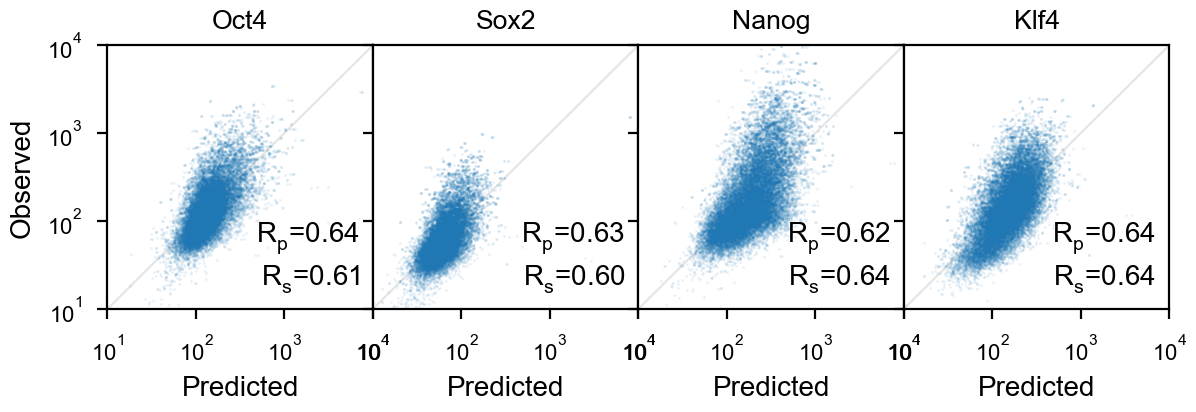

In [53]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()
fig.savefig(fdir / 'calibrated,linear.total-counts.scatter-no-hidden.pdf')

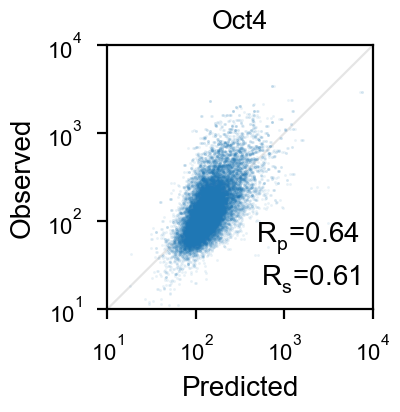

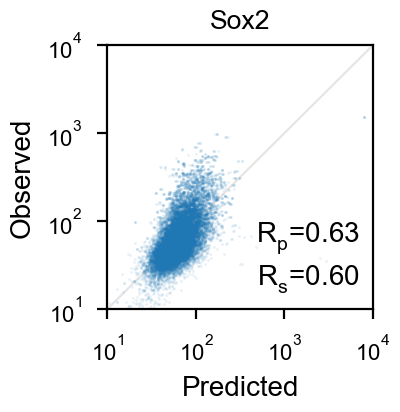

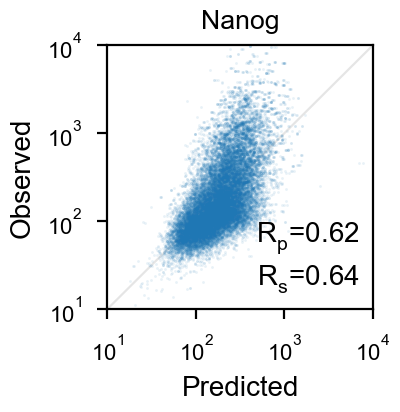

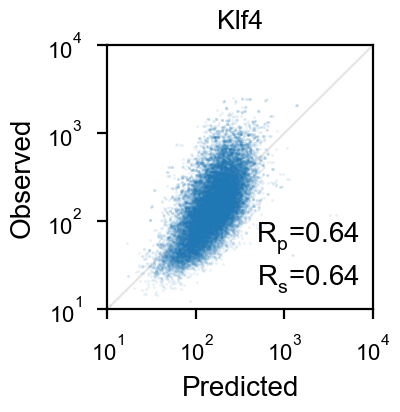

In [54]:
for task in tasks:
    fig, ax= plt.subplots(figsize=get_figsize(frac=0.25, aspect=1))
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    plt.minorticks_off()
    # save the figure
    os.makedirs(f"{fdir}/scatter", exist_ok=True)
    fig.savefig(f"{fdir}/scatter/calibrated,linear.{task}.pdf")
    fig.savefig(f"{fdir}/scatter/calibrated,linear.{task}.png")

### With hidden layer

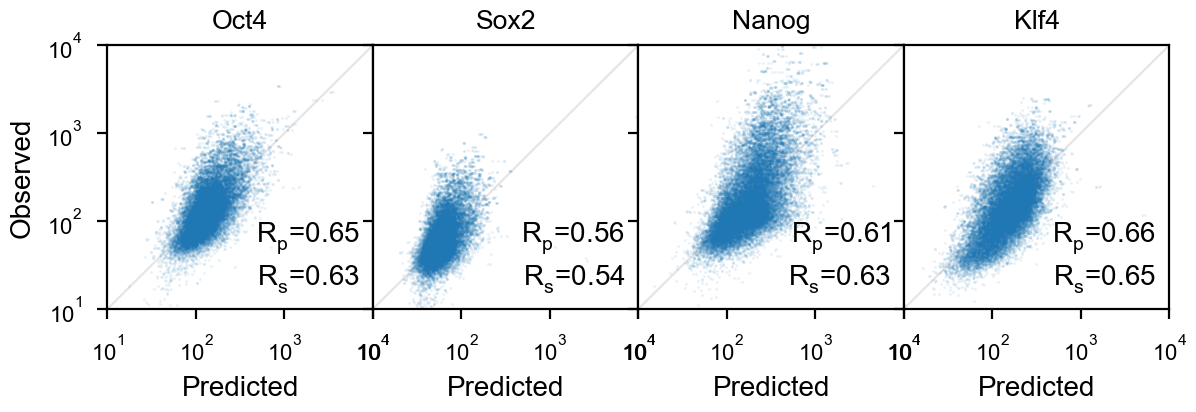

In [49]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()
fig.savefig(fdir / 'calibrated,hidden+bn.total-counts.scatter.pdf')

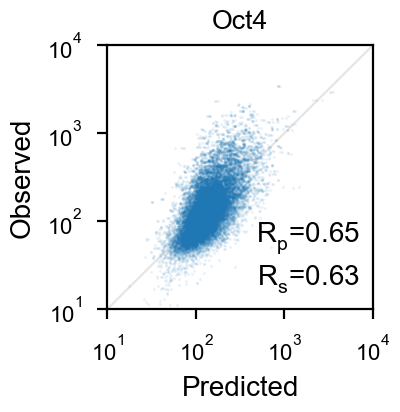

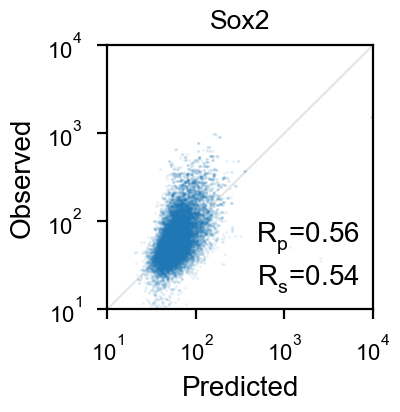

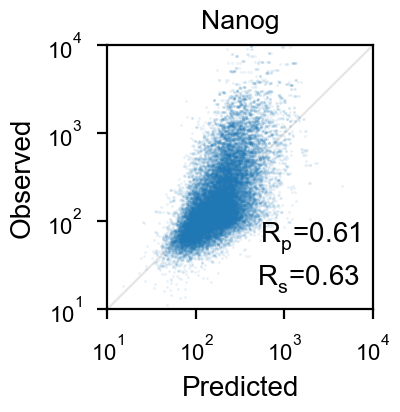

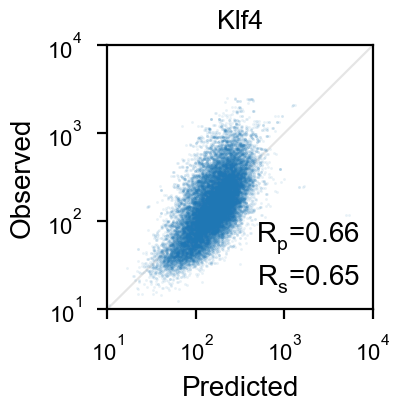

In [50]:
for task in tasks:
    fig, ax= plt.subplots(figsize=get_figsize(frac=0.25, aspect=1))
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    plt.minorticks_off()
    # save the figure
    os.makedirs(f"{fdir}/scatter", exist_ok=True)
    fig.savefig(f"{fdir}/scatter/calibrated,hidden+bn.{task}.pdf")
    fig.savefig(f"{fdir}/scatter/calibrated,hidden+bn.{task}.png")

### Old model

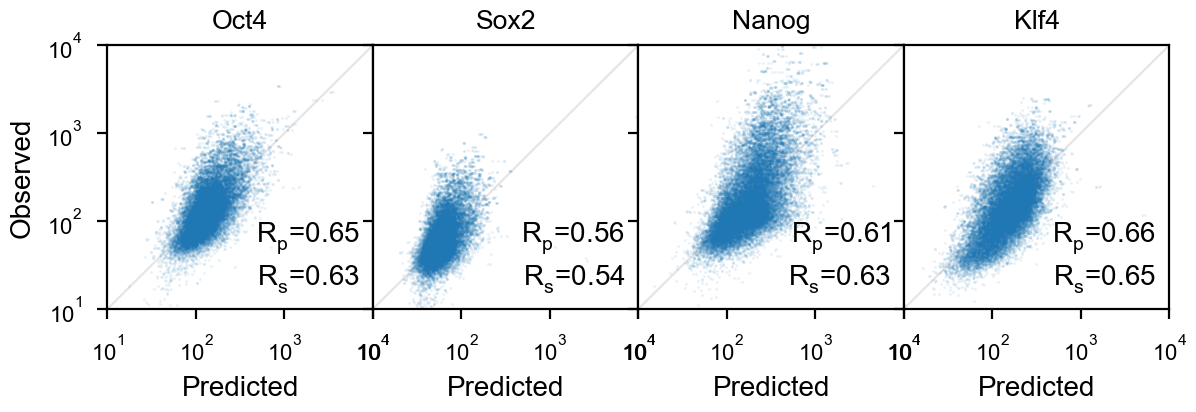

In [26]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()

### TODO

- overwrite the parameters in the old model

In [59]:
h = counts_model.heads[0]

In [67]:
h = counts_model.all_heads["Oct4"][0]

In [82]:
l = counts_model.model.layers[-1]

In [113]:
calibrated_dense_layers = {"Oct4": "dense_21",
               "Sox2": "dense_23",
               "Nanog": "dense_25",
               "Klf4": "dense_27"}

In [114]:
calibrated_bias_layers = {"Oct4": "dense_22",
               "Sox2": "dense_24",
               "Nanog": "dense_26",
               "Klf4": "dense_28"}

In [115]:
orig_dense_layers = {"Oct4": "dense_1",
               "Sox2": "dense_3",
               "Nanog": "dense_5",
               "Klf4": "dense_7"}

In [116]:
orig_bias_layers = {"Oct4": "dense_2",
               "Sox2": "dense_4",
               "Nanog": "dense_6",
               "Klf4": "dense_8"}

In [121]:
# calibrate the model
for tf in bpnet.tasks:
    bpnet.model.get_layer(orig_bias_layers[tf]).set_weights(counts_model.model.get_layer(calibrated_bias_layers[tf]).get_weights())
    bpnet.model.get_layer(orig_dense_layers[tf]).set_weights(counts_model.model.get_layer(calibrated_dense_layers[tf]).get_weights())

In [123]:
bpnet.save(str(model_dir / 'calibrated_seqmodel.pkl'))

### Test predictions

In [125]:
y_pred = bpnet.predict(valid['inputs'])
y_true = valid['targets']

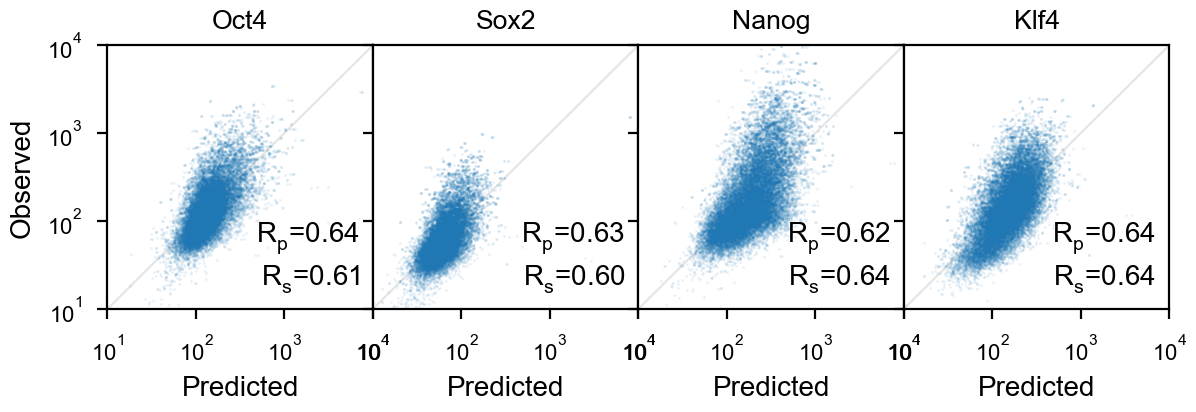

In [126]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()
# fig.savefig(fdir / 'calibrated,linear.total-counts.scatter-no-hidden.pdf')

----------------

### New model

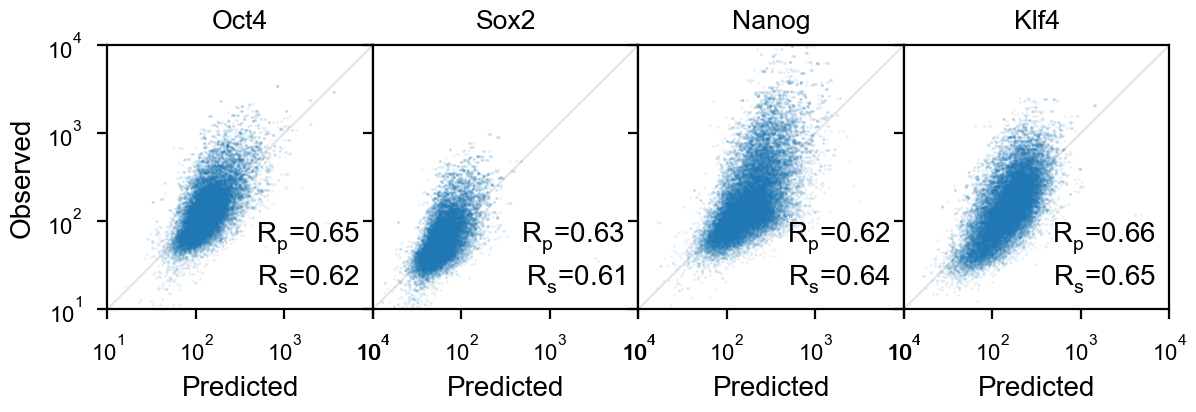

In [70]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'{task}/counts'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()

### Old model

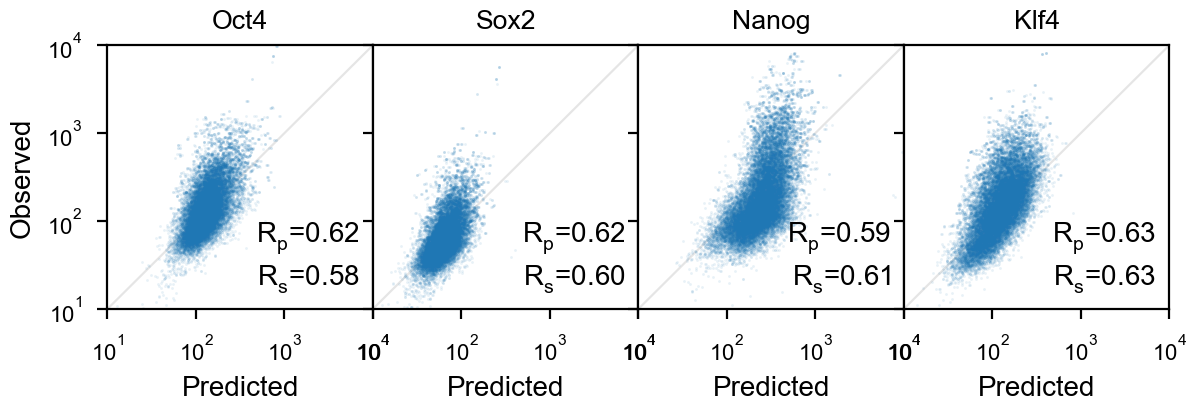

In [14]:
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(frac=1, aspect=1/len(tasks)),
                         sharex=True, sharey=True)
for i, (task, ax) in enumerate(zip(tasks, axes)):
    yt = np.exp(y_true[f'counts/{task}'].mean(-1))
    yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
    xrange = [10, 1e4]
    ax.set_ylim(xrange)
    ax.set_xlim(xrange)
    
    ax.plot(xrange, xrange, c='grey', alpha=0.2)
    regression_eval(yt, 
                    yp, alpha=.1, task=task, ax=ax, loglog=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
    if i > 0:
        ax.set_ylabel("")
fig.subplots_adjust(wspace=0)
plt.minorticks_off()